In [2]:
import numpy as np
import pandas as pd
from numpy import mgrid
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [8]:
dataset_1_train = pd.read_csv('BC-Train1.csv', header=None)
dataset_1_test = pd.read_csv('BC-Test1.csv', header=None)
dataset_2_train = pd.read_csv('BC-Train2.csv', header=None)
dataset_2_test = pd.read_csv('BC-Test2.csv', header=None)
dataset_1_train

,0,1,2
0,0.57287,0.051784,1
1,1.51080,-0.332330,1
2,0.34373,1.956700,1
3,0.87498,-1.082100,1
4,0.46953,-0.641320,1
...,...,...,...
795,5.40390,5.096800,0
796,6.19250,3.670300,0
797,3.31520,7.905500,0
798,5.41310,7.759700,0


In [20]:
class BeyesianClassifier:
    def __init__(self, train_data: pd.DataFrame, test_data: pd.DataFrame):
        self.X_train = train_data[train_data.columns[0:2]].to_numpy()
        self.y_train = train_data[train_data.columns[2:3]].to_numpy().reshape(self.X_train.shape[0],)
        self.X_test = test_data[test_data.columns[0:2]].to_numpy()
        self.y_test = test_data[test_data.columns[2:3]].to_numpy().reshape(self.X_test.shape[0],)
        self.m, self.n = self.X_train.shape
        self.phis = []
        self.mus = []
        self.sigmas = []
        self.number_of_class = len(np.unique(self.y_train))

    def find_parameters(self):
        classes_sum = np.bincount(self.y_train)
        self.phis = classes_sum/self.m
        for i in range(self.number_of_class):
            x_avg = self.X_train[self.y_train==i].mean(0)
            self.mus.append(x_avg)
        for i in range(self.number_of_class):
            x_class = self.X_train[self.y_train==i] - self.mus[i]
            cov = x_class.T @ x_class / x_class.shape[0]
            self.sigmas.append(cov)

    def predict(self, input):
        class_likelihood = []
        for i in range (self.number_of_class):
            X = input - self.mus[i]
            mapping = np.linalg.inv(self.sigmas[i]) @ X.T # output shape: 2 x 400
            likelihood = np.exp(-0.5*(mapping.T * X).sum(1)) / ((((2*np.pi)**0.5)**self.n) * (np.linalg.det(self.sigmas[i])**0.5))
            posteriori = likelihood * self.phis[i]
            class_likelihood.append(posteriori)
        return np.stack(class_likelihood)

    def accuracy_precisions_recalls_f1(self):
        print("Test Data:")
        y_hat_test = self.predict(self.X_test).argmax(0)
        one_hot_y_hat_test = np.zeros((y_hat_test.size, y_hat_test.max() + 1))
        one_hot_y_hat_test[np.arange(y_hat_test.size), y_hat_test] = 1
        y_true_test = self.y_test
        one_hot_y_true_test = np.zeros((y_true_test.size, y_true_test.max() + 1))
        one_hot_y_true_test[np.arange(y_true_test.size), y_true_test] = 1
        test_confusion_matrix = one_hot_y_hat_test.T @ one_hot_y_true_test
        print("Confusion Matrix: \n", test_confusion_matrix)
        print("Accuracy: {} %".format((np.diag(test_confusion_matrix).sum()/test_confusion_matrix.sum())*100))
        print("Precision: {} %".format(test_confusion_matrix[0, 0]/test_confusion_matrix.sum(1)[0]*100))
        print("Recall: {} %".format(test_confusion_matrix[0, 0]/test_confusion_matrix.sum(0)[0]*100))
        print("F1: {}".format(2*((test_confusion_matrix[0, 0]/test_confusion_matrix.sum(1)[0])*(test_confusion_matrix[0, 0]
                                /test_confusion_matrix.sum(0)[0]))/((test_confusion_matrix[0, 0]/test_confusion_matrix.sum(1)[0])
                                +(test_confusion_matrix[0, 0] /test_confusion_matrix.sum(0)[0]))))
        print("Train Data:")
        y_hat_train = self.predict(self.X_train).argmax(0)
        one_hot_y_hat_train = np.zeros((y_hat_train.size, y_hat_train.max() + 1))
        one_hot_y_hat_train[np.arange(y_hat_train.size), y_hat_train] = 1
        y_true_train = self.y_train
        one_hot_y_true_train = np.zeros((y_true_train.size, y_true_train.max() + 1))
        one_hot_y_true_train[np.arange(y_true_train.size), y_true_train] = 1
        train_confusion_matrix = one_hot_y_hat_train.T @ one_hot_y_true_train
        print("Confusion Matrix: \n", train_confusion_matrix)
        print("Accuracy: {} %".format((np.diag(train_confusion_matrix).sum()/train_confusion_matrix.sum())*100))
        print("Precision: {} %".format(train_confusion_matrix[0, 0]/train_confusion_matrix.sum(1)[0]*100))
        print("Recall: {} %".format(train_confusion_matrix[0, 0]/train_confusion_matrix.sum(0)[0]*100))
        print("F1: {}".format(2*((train_confusion_matrix[0, 0]/train_confusion_matrix.sum(1)[0])*(train_confusion_matrix[0, 0]
                                /train_confusion_matrix.sum(0)[0]))/((train_confusion_matrix[0, 0]/train_confusion_matrix.sum(1)[0])
                                +(train_confusion_matrix[0, 0] /train_confusion_matrix.sum(0)[0]))))

    def draw_decision_boundary(self):
        x = np.linspace(np.min(self.X_train[:, 0] ), np.max(self.X_train[:, 0]))
        fig, ax = plt.subplots()
        ax.set_aspect("equal")
        b = (0.5 * self.mus[0].T @ np.linalg.inv(self.sigmas[0]) @ self.mus[0]) + (-0.5 * self.mus[1].T @ np.linalg.inv(self.sigmas[1]) @ self.mus[1]) - np.log(self.phis[0]/self.phis[1])
        a = np.linalg.inv(self.sigmas[0]) @ (self.mus[1] - self.mus[0])
        y_hat_train = self.predict(self.X_train).argmax(0)
        index = np.where(y_hat_train != self.y_train)
        plt.plot(x, ((-a[0]*x)-b)/a[1])
        train_colors=['red' if l==0 else 'blue' for l in self.y_train[:]]
        test_colors=['red' if l==0 else 'blue' for l in self.y_test[:]]
        plt.scatter(self.X_train[:, 0], self.X_train[:, 1],marker=".", color=train_colors)
        plt.scatter(self.X_train[index, 0], self.X_train[index, 1],marker="s", facecolor="none", edgecolor='black')
        plt.scatter(self.X_test[:, 0], self.X_test[:, 1],marker="+", color=test_colors)
        plt.ylim(-5,13)
        plt.show()

    def draw_decision_boundary2(self):
        fig, ax = plt.subplots()
        ax.set_aspect("equal")
        y_hat_train = self.predict(self.X_train).argmax(0)
        index = np.where(y_hat_train != self.y_train)
        x, y = mgrid[np.min(self.X_train[:, 0] ):np.max(self.X_train[:, 0]):0.01, np.min(self.X_train[:, 1] ):np.max(self.X_train[:, 1]):0.01]
        x_1 = np.stack([x,y], -1).reshape(-1, 2)
        out = self.predict(x_1)
        f = out[1] - out[0]
        f = f.reshape(x.shape)
        plt.contour(x, y, f, 0)
        train_colors=['red' if l==0 else 'blue' for l in self.y_train[:]]
        test_colors=['red' if l==0 else 'blue' for l in self.y_test[:]]
        plt.scatter(self.X_train[:, 0], self.X_train[:, 1],marker=".", color=train_colors)
        plt.scatter(self.X_train[index, 0], self.X_train[index, 1], marker="s", facecolor="none", edgecolor='black')
        plt.scatter(self.X_test[:, 0], self.X_test[:, 1],marker="+", color=test_colors)
        plt.show()
    
    def plot_pdf(self):
        x, y = mgrid[np.min(self.X_train[:, 0] ):np.max(self.X_train[:, 0]):0.01, np.min(self.X_train[:, 1] ):np.max(self.X_train[:, 1]):0.01]
        xy = np.column_stack([x.flat, y.flat])
        i = 0
        X = xy - self.mus[i]
        mapping = np.linalg.inv(self.sigmas[i]) @ X.T # output shape: 2 x 400
        likelihood = np.exp(-0.5*(mapping.T * X).sum(1)) / ((((2*np.pi)**0.5)**self.n) * (np.linalg.det(self.sigmas[i])**0.5))
        prob1 = likelihood
        prob1 = prob1.reshape(x.shape)
        i = 1
        X = xy - self.mus[i]
        mapping = np.linalg.inv(self.sigmas[i]) @ X.T # output shape: 2 x 400
        likelihood = np.exp(-0.5*(mapping.T * X).sum(1)) / ((((2*np.pi)**0.5)**self.n) * (np.linalg.det(self.sigmas[i])**0.5))
        prob2 = likelihood
        prob2 = prob2.reshape(x.shape)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(x,y,np.maximum(prob1,prob2), cmap=cm.coolwarm)
        plt.show()
        
    def plot_contour(self):
        fig, ax = plt.subplots()
        fig.set_size_inches(20,10)
        ax.set_aspect("equal")
        y_hat_train = self.predict(self.X_train).argmax(0)
        index = np.where(y_hat_train != self.y_train)
        x, y = mgrid[np.min(self.X_train[:, 0] ):np.max(self.X_train[:, 0]):0.01, np.min(self.X_train[:, 1] ):np.max(self.X_train[:, 1]):0.01]
        x_1 = np.stack([x,y], -1).reshape(-1, 2)
        out = self.predict(x_1)
        f = out[1] - out[0]
        f = f.reshape(x.shape)
        plt.contour(x, y, f)
        train_colors=['red' if l==0 else 'blue' for l in self.y_train[:]]
        test_colors=['red' if l==0 else 'blue' for l in self.y_test[:]]
        plt.show()


Test Data:
Confusion Matrix: 
 [[50.  0.]
 [ 0. 50.]]
Accuracy: 100.0 %
Precision: 100.0 %
Recall: 100.0 %
F1: 1.0
Train Data:
Confusion Matrix: 
 [[396.   5.]
 [  4. 395.]]
Accuracy: 98.875 %
Precision: 98.75311720698254 %
Recall: 99.0 %
F1: 0.9887640449438203


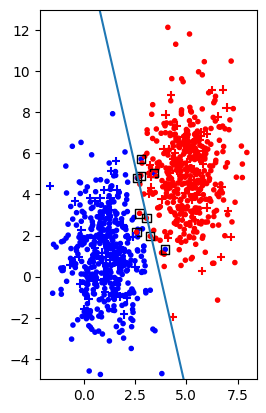

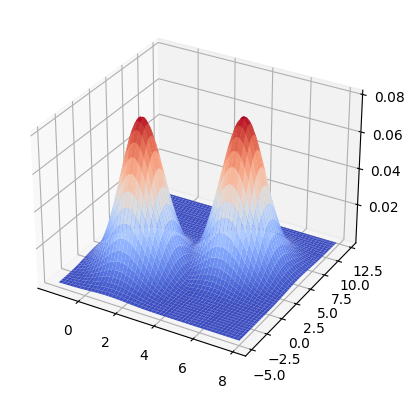

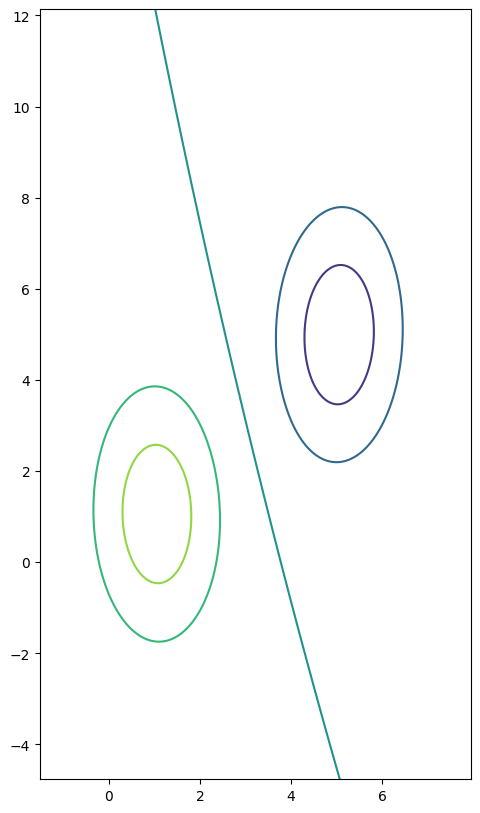

[array([[0.98559161, 0.08682345],
        [0.08682345, 3.96907885]]),
 array([[ 0.98916202, -0.06353189],
        [-0.06353189,  3.99916563]])]

In [21]:
first_classifier = BeyesianClassifier(dataset_1_train, dataset_1_test)
first_classifier.find_parameters()
first_classifier.accuracy_precisions_recalls_f1()
first_classifier.draw_decision_boundary()
first_classifier.plot_pdf()
first_classifier.plot_contour()

Test Data:
Confusion Matrix: 
 [[50.  0.]
 [ 0. 50.]]
Accuracy: 100.0 %
Precision: 100.0 %
Recall: 100.0 %
F1: 1.0
Train Data:
Confusion Matrix: 
 [[399.   0.]
 [  1. 400.]]
Accuracy: 99.875 %
Precision: 100.0 %
Recall: 99.75 %
F1: 0.9987484355444306


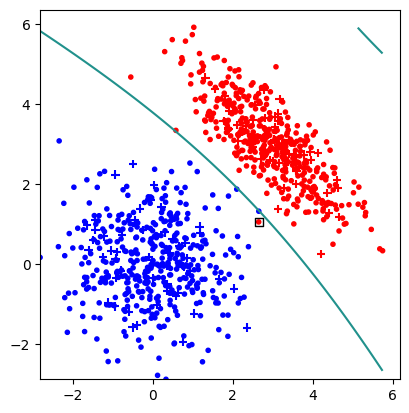

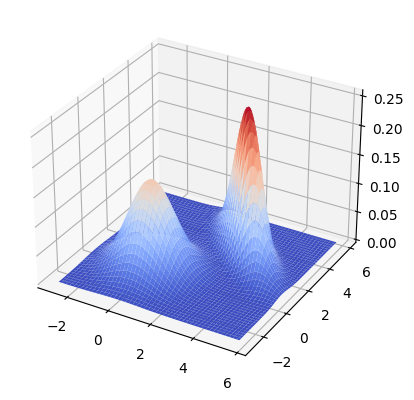

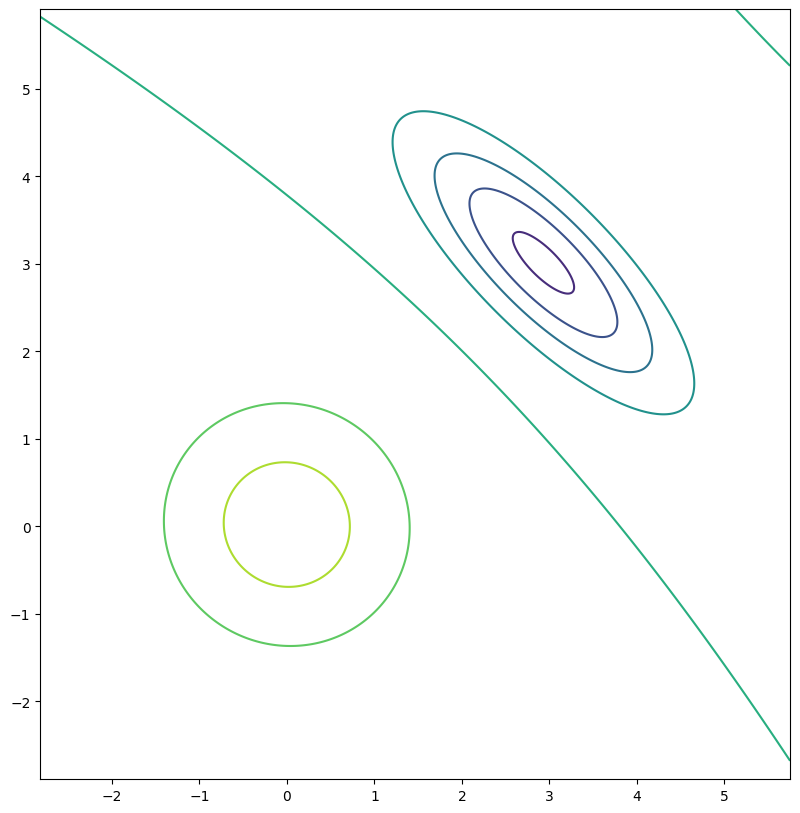

[array([[ 1.02744599, -0.82188321],
        [-0.82188321,  1.03709589]]),
 array([[ 1.0482398 , -0.03059561],
        [-0.03059561,  1.02329013]])]

In [22]:
second_classifier = BeyesianClassifier(dataset_2_train, dataset_2_test)
second_classifier.find_parameters()
second_classifier.accuracy_precisions_recalls_f1()
second_classifier.draw_decision_boundary2()
second_classifier.plot_pdf()
second_classifier.plot_contour()